<a href="https://colab.research.google.com/github/mojgan65/Stock_prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import glob

tf.random.set_seed(42)

In [2]:
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    # df['Date'] = pd.to_datetime(df['Date'])

    # convert them to float
    df['Close'] = df['Close'].str.replace(',', '')
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Open'] = df['Open'].str.replace(',', '')
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['High'] = df['High'].str.replace(',', '')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = df['Low'].str.replace(',', '')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [4]:
data_raw = pd.read_csv('data.csv', index_col='Date')
data = generate_features(data_raw)

In [5]:
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing

data_train = data.iloc[:train_size]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

data_test = data.iloc[train_size:]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [6]:
learning_rate = 0.3
epocs_num = 1000
units= 64

model = Sequential([
    Dense(units=units, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model.fit(X_scaled_train, y_train, epochs=epocs_num, verbose=True)

predictions = model.predict(X_scaled_test)[:, 0]


Epoch 1/1000
170/170 [==============================] - 1s 2ms/step - loss: 20059862.0000
Epoch 2/1000
170/170 [==============================] - 0s 2ms/step - loss: 1002996.8750
Epoch 3/1000
170/170 [==============================] - 0s 2ms/step - loss: 278809.6250
Epoch 4/1000
170/170 [==============================] - 0s 2ms/step - loss: 82539.5469
Epoch 5/1000
170/170 [==============================] - 0s 2ms/step - loss: 40794.9492
Epoch 6/1000
170/170 [==============================] - 0s 2ms/step - loss: 30262.0117
Epoch 7/1000
170/170 [==============================] - 0s 2ms/step - loss: 54501.7461
Epoch 8/1000
170/170 [==============================] - 0s 2ms/step - loss: 64567.3477
Epoch 9/1000
170/170 [==============================] - 0s 2ms/step - loss: 35302.9805
Epoch 10/1000
170/170 [==============================] - 0s 2ms/step - loss: 65306.4141
Epoch 11/1000
170/170 [==============================] - 0s 2ms/step - loss: 148014.0781
Epoch 12/1000
170/170 [===========

In [7]:
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

MSE: 831.073
MAE: 22.630
R^2: 0.999


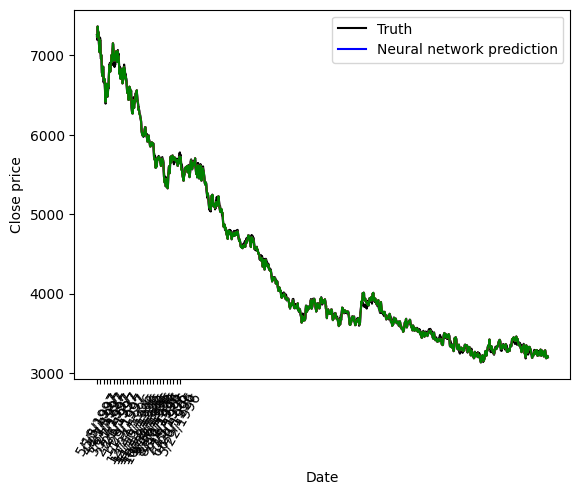

In [8]:
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions, c='r')
plt.plot(data_test.index, predictions, c='g')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction'])
plt.show()